In [109]:
import os
import copy

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, mark_boundaries
from skimage.exposure import histogram
from skimage.morphology import remove_small_objects, binary_closing, skeletonize
from skimage.transform import resize, rotate

In [3]:
!tree 

.
├── oil_analysis.ipynb
├── storage_tanks.jpg
└── tank_1.jpg

0 directories, 3 files


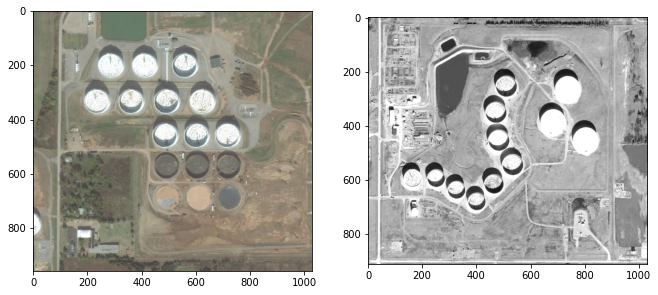

In [93]:
tank = plt.imread('storage_tanks.jpg')
tank1 = plt.imread('storage_tanks_2.jpg')
f = plt.figure(figsize=(11, 11))
ax = f.add_subplot(121)
ax.imshow(tank, cmap='gray')
ax1 = f.add_subplot(122)
ax1.imshow(tank1, cmap='gray')

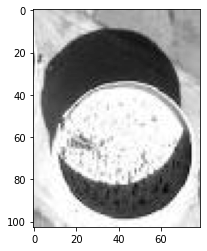

In [103]:
img = cv2.imread('tank_3.jpg', 0)
plt.imshow(img, cmap='gray')

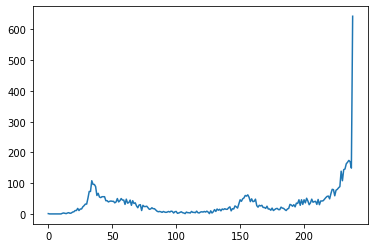

In [104]:
hist, hist_centers = histogram(img)
plt.plot(hist)

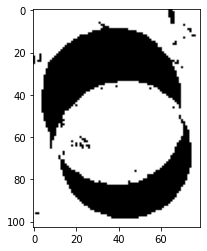

In [105]:
img = np.uint8(cv2.normalize(img.copy(), None, 0, 255, cv2.NORM_MINMAX))
ret, img = cv2.threshold(img, 255, 255, cv2.THRESH_OTSU)
plt.imshow(img, cmap='gray')

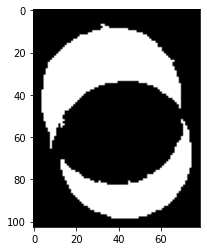

In [106]:
img = np.invert(img)
shadow = img > 0
clean = remove_small_objects(shadow, min_size=300)
clean = remove_small_objects(clean, min_size=300)
# xl,xr = x.min(),x.max()
# puff_cl = puff_cl[xl-10:xr+1, :]
plt.imshow(clean, cmap='gray')

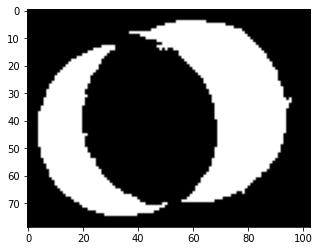

In [114]:
img_rot = copy.copy(clean)
img_rot = rotate(img_rot, -90, resize=True)
img_rot = np.uint8(img_rot)
plt.imshow(img_rot, cmap='gray')

(79, 103)

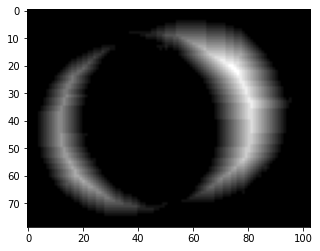

In [122]:
dists = cv2.distanceTransform(img_rot.copy(), cv2.DIST_L1, 5)

plt.imshow(dists, cmap='gray')

dists.shape

In [ ]:
'''
If detection bounding box is centred around tank+shadow, can assume each shadow exists on one half of the box. 

Internal shadow: only consider widths with an x_pos < 0.5 * img.shape[1]
External shadow: only consider widths.x_pos >= 0.5 *  img.shape[1]
''' 

In [127]:
inside_shadow_widths = []
inside_positions = []
outside_shadow_widths = []
outside_positions = []

for i, row in enumerate(dists):
    
    row_widths = [j for j in row]
    
    in_widths = row_widths[:(int(0.5*len(row_widths)))]
    out_widths = row_widths[(int(0.5*len(row_widths))):]
    
    inside_shadow_widths.append(max(in_widths))
    outside_shadow_widths.append(max(out_widths))
    
    xpos_in = in_widths.index(max(in_widths))
    xpos_out = out_widths.index(max(out_widths))
    
    inside_positions.append((i, xpos_in))
    outside_positions.append((i, xpos_out+int(0.5*len(row_widths))))

In [129]:
print(inside_shadow_widths)
print(outside_shadow_widths)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 4.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 8.0, 8.0, 7.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 13.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 13.0, 14.0, 14.0, 14.0, 14.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 11.0, 10.0, 10.0, 9.0, 9.0, 8.0, 8.0, 7.0, 6.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [121]:
vals = [(w, pos) for w, pos in zip(widths, positions)]

[(0.0, (0, 0)), (0.0, (1, 0)), (0.0, (2, 0)), (0.0, (3, 0)), (2.0, (4, 54)), (4.0, (5, 54)), (6.0, (6, 54)), (8.0, (7, 54)), (10.0, (8, 54)), (12.0, (9, 54)), (14.0, (10, 56)), (16.0, (11, 58)), (18.0, (12, 60)), (20.0, (13, 62)), (22.0, (14, 64)), (22.0, (15, 65)), (24.0, (16, 66)), (26.0, (17, 68)), (28.0, (18, 70)), (28.0, (19, 71)), (30.0, (20, 73)), (30.0, (21, 74)), (30.0, (22, 75)), (30.0, (23, 76)), (28.0, (24, 76)), (28.0, (25, 77)), (28.0, (26, 77)), (28.0, (27, 78)), (28.0, (28, 78)), (28.0, (29, 79)), (28.0, (30, 79)), (26.0, (31, 79)), (28.0, (32, 80)), (28.0, (33, 80)), (28.0, (34, 81)), (28.0, (35, 81)), (26.0, (36, 80)), (26.0, (37, 80)), (26.0, (38, 80)), (26.0, (39, 80)), (26.0, (40, 81)), (26.0, (41, 81)), (26.0, (42, 81)), (26.0, (43, 81)), (26.0, (44, 81)), (24.0, (45, 80)), (24.0, (46, 80)), (24.0, (47, 80)), (24.0, (48, 80)), (24.0, (49, 80)), (24.0, (50, 79)), (24.0, (51, 79)), (24.0, (52, 79)), (24.0, (53, 79)), (24.0, (54, 78)), (22.0, (55, 77)), (20.0, (56, 7

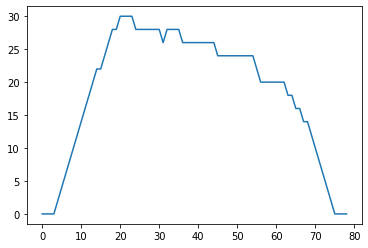

In [119]:
plt.plot(range(img_rot.shape[0]), widths)

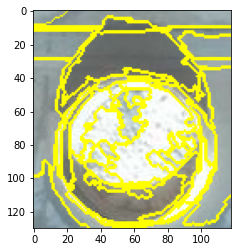

In [23]:
img_smooth = cv2.GaussianBlur(img.copy(),(9,9), 0)
img_smooth = np.uint8(cv2.normalize(img_smooth, None, 0, 255, cv2.NORM_MINMAX))
segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
plt.imshow(mark_boundaries(img, segments_fz))

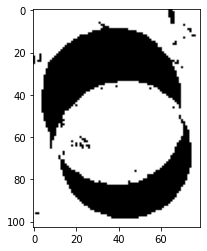